In [1]:
import torch
import imp
import ppuu.costs
import ppuu.costs.policy_costs_km

imp.reload(ppuu.costs.policy_costs_km)
PolicyCostKMTaper = ppuu.costs.policy_costs_km.PolicyCostKMTaper

from ppuu.data.dataloader import DataStore, Dataset, Normalizer
from ppuu.data.constants import UnitConverter
from ppuu import configs

NPRED = 30
store = DataStore('/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/')
ds = Dataset(store, 'train', 20, NPRED, 40, shift=False, random_actions=False)
loader = torch.utils.data.DataLoader(ds, batch_size=1)
normalizer = Normalizer(store.stats)

In [2]:
from ppuu.lightning_modules.fm import FM

m_config = FM.Config()
m_config.model.fm_type = "km_no_action"
m_config.model.checkpoint = "/home/us441/nvidia-collab/vlad/results/fm/km_no_action/fm_km_no_action_64/seed=42/checkpoints/last.ckpt"
m_config.training.enable_latent = True
m_config.training.diffs = False
forward_model = FM(m_config).cuda()
forward_model._setup_normalizer(store.stats)
forward_model.model.device = torch.device('cuda')

In [3]:
from ppuu.data import NGSIMDataModule

datamodule = NGSIMDataModule(
        '/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/',
        100,
        100,
        6,
        workers=0,
        diffs=False,
        npred=NPRED,
    )
datamodule.setup()

In [4]:
tdl = datamodule.train_dataloader()

In [5]:
b = next(iter(tdl))

In [7]:
type(b)

ppuu.data.entities.DatasetSample

In [5]:
import yaml
from pathlib import Path

from ppuu.modeling.policy.mpc import MPCKMPolicy
import ppuu.eval_mpc


def get_mpc(path, km_cost = None):
    path = Path(path)
    with path.open('r') as f:
        config_yaml = yaml.load(f)
    config = ppuu.eval_mpc.EvalMPCConfig.parse_from_dict(config_yaml)
    config.mpc.planning_freq = 1
    config.mpc.clip_actions = 5
    if km_cost is None:
        km_cost_config = config.cost
        # km_cost_config.lambda_a = 0.001
        km_cost_config.build_overlay = True
        km_cost_config.lambda_a = 0
        km_cost = ppuu.costs.PolicyCostKMTaper(km_cost_config, None, normalizer)
    km_mpc = MPCKMPolicy(forward_model.model, km_cost, normalizer, config.mpc, None)
    return km_mpc

def get_sgd_mpc(cost = None):
    return get_mpc('/home/us441/configs/best_grid.yaml', cost)

def get_lbfgs_mpc(cost):
    return get_mpc('/home/us441/configs/best_lbfgs.yaml', cost)

def get_greedy_mpc(cost):
    return get_mpc('/home/us441/configs/best_greedy.yaml', cost)

def get_ce_mpc(cost):
    return get_mpc('/home/us441/configs/best_ce.yaml', cost)

sgd_mpc = get_sgd_mpc()

mpcs = {
    'greedy': get_greedy_mpc(sgd_mpc.cost),
    'ce': get_ce_mpc(sgd_mpc.cost),
    'lbfgs': get_lbfgs_mpc(sgd_mpc.cost),
    'sgd': sgd_mpc,
}

<ipython-input-5-f25ee7a9dc09>:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config_yaml = yaml.load(f)


In [6]:
it = iter(loader)
batch = next(it)
print(batch.conditional_state_seq.images.shape)
print(batch.conditional_state_seq.ego_car_image.shape)

torch.Size([1, 20, 3, 117, 24])
torch.Size([1, 3, 117, 24])


torch.Size([1, 2])


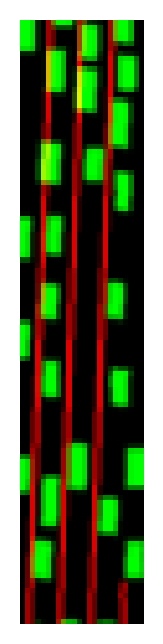

In [217]:
from matplotlib import pyplot as plt
plt.figure(dpi=200)
plt.axis('off')
plt.imshow(batch.target_state_seq.images[0][0].permute(1, 2, 0))
print(batch.target_state_seq.car_size.shape)

In [218]:
batch.conditional_state_seq.images.shape

torch.Size([1, 20, 3, 117, 24])

# Getting cost surface

In [219]:
K = 5
N = 200
xx, yy, a = mpcs['greedy']._try_action_grid(
    batch.conditional_state_seq.with_ego().cuda(),
    future_context_state_seq=batch.target_state_seq.map(lambda x : x.unsqueeze(1)).cuda(),
    points=N,
    search_range=K,
)

torch.Size([1, 200, 200])


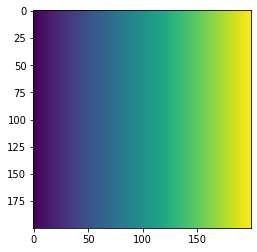

In [231]:
print(xx.shape)
plt.imshow(yy.cpu()[0])

# Getting greedy action

In [220]:
idx = torch.argmin(a.flatten())
mn_v = a.flatten()[idx]
mn_a = xx.flatten()[idx]
mn_t = yy.flatten()[idx]

# Getting all mpcs' actions

In [221]:
def transform_history(hist):
    firsts = list(map(lambda x : x[:, :, 0].view(-1, 2), hist))
    firsts = torch.cat(firsts, dim=0)
    sizes = torch.linspace(0, 1, len(hist))
    sizes = torch.repeat_interleave(sizes, firsts.shape[0] // len(hist))
    assert firsts.shape[0] == sizes.shape[0]
    return firsts, sizes
    
mpc_actions = {}
mpc_costs = {}
mpc_histories = {}
mpc_sizes = {}

for name, mpc in mpcs.items():
    print(name)
    metadata = {}
    km_actions = mpc(batch.conditional_state_seq.with_ego().cuda(),
                     normalize_inputs=False,
                     gt_future=lambda : batch.target_state_seq.cuda(),
                     metadata=metadata)
    mpc_actions[name] = km_actions
    if metadata['action_history'] is not None and len(metadata['action_history']) > 0:
        hist, sizes = transform_history(metadata['action_history'])
        mpc_histories[name] = hist
        mpc_sizes[name] = sizes
        print(f'{mpc_histories[name].shape=}')
    else:
        mpc_histories[name] = None

greedy
final actions for 1 are tensor([[-0.5102, -0.9184]], device='cuda:0')
ce
final actions for 1 are tensor([[-0.4764, -0.9212]], device='cuda:0', grad_fn=<SelectBackward>)
mpc_histories[name].shape=torch.Size([900, 2])
lbfgs
final actions for 1 are tensor([[-0.0813, -0.3799]], device='cuda:0')
mpc_histories[name].shape=torch.Size([63, 2])
sgd
final actions for 1 are tensor([[-0.1062, -1.5873]], device='cuda:0')
mpc_histories[name].shape=torch.Size([75, 2])


# Getting GT actions

In [222]:
true_acc, true_turn = batch.target_action_seq[0, 0]

# Plotting the results

Text(0.5, 1.0, 'costs over actions')

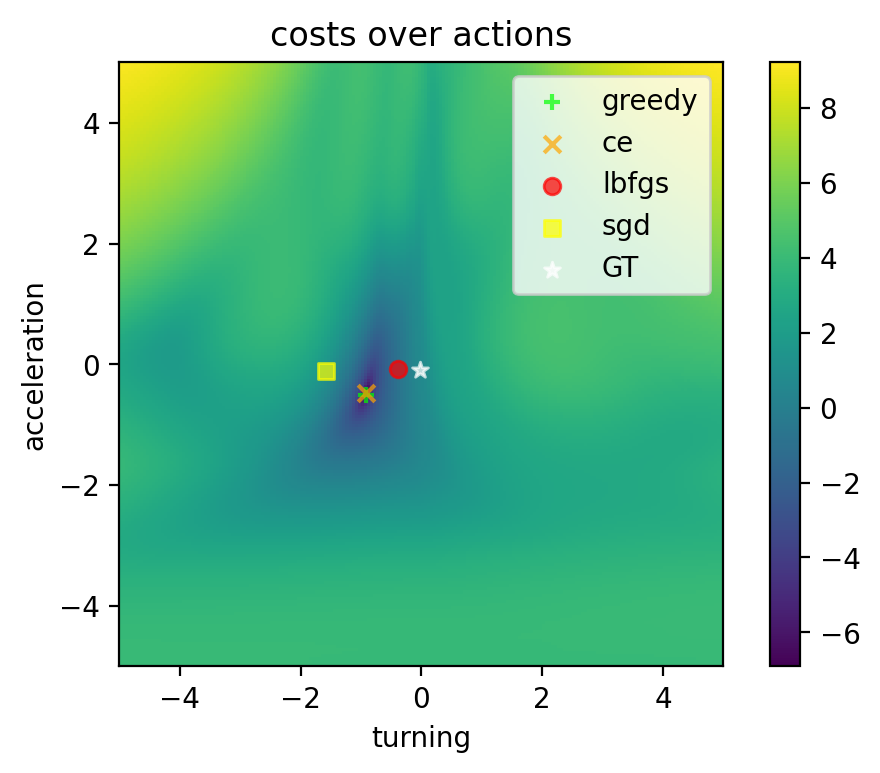

In [223]:
b = torch.clamp((a - a.min()), min=1e-3, max=None)#/ (a.max() - a.min())
b = b.log()
plt.figure(dpi=200)
plt.imshow(b[0].detach().cpu(), extent=[-K, K, -K, K])
plt.colorbar()
#ticks = torch.linspace(0, 1, 11)
#tick_labels = torch.log(torch.exp(ticks + torch.log(a.max() - a.min())) + a.min())
#cbar = plt.colorbar(ticks=ticks)
#cbar.ax.set_yticklabels(map(lambda x : f"{x.item():.2f}", tick_labels))
# plt.scatter(y, x, c=torch.linspace(0, 1, len(x)), cmap='inferno')

markers = [('+', 'lime', ''), 
           ('x', 'orange', ''),
           ('o', 'red', ''),
           ('s', 'yellow', ''),
          ]

for i, (name, actions) in enumerate(mpc_actions.items()):
#     if mpc_histories[name] is not None:
#         plt.scatter(mpc_histories[name][:,1].cpu(), mpc_histories[name][:,0].cpu(), c=markers[i][1], marker=markers[i][0], s=mpc_sizes[name]*4, alpha=0.8, cmap='viridis')
    plt.scatter(actions[0,1].cpu(), actions[0, 0].cpu(), marker=markers[i][0], c=markers[i][1], label=name, alpha=0.7)
    
plt.scatter(true_turn.cpu(), true_acc.cpu(), marker='*', c='white', label='GT', alpha=0.7)
plt.legend()
plt.xlabel('turning')
plt.ylabel('acceleration')
plt.title('costs over actions')

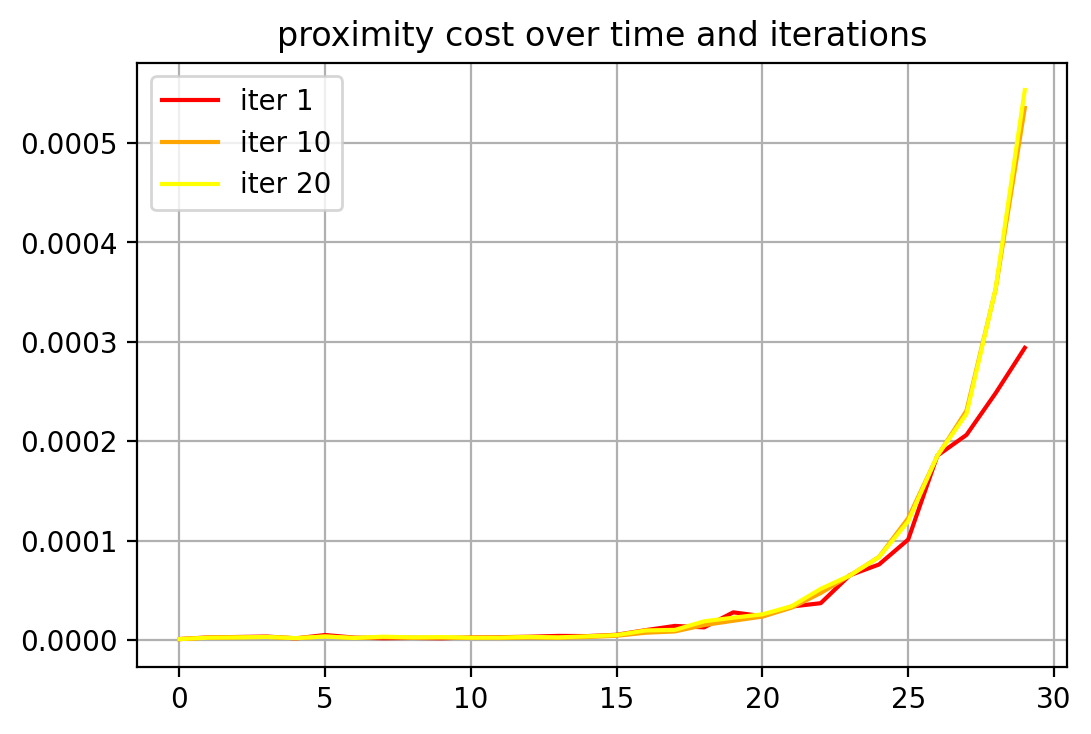

In [232]:
plt.figure(dpi=200)
plt.plot(metadata['costs'][0].state.proximity[0].detach().cpu(), c='r', label='iter 1')
plt.plot(metadata['costs'][9].state.proximity[0].detach().cpu(), c='orange', label='iter 10')
plt.plot(metadata['costs'][19].state.proximity[0].detach().cpu(), c='yellow', label='iter 20')
# plt.plot(metadata['costs'][20].state.proximity[0].detach().cpu(), c='green', label='iter 30')
plt.grid()
plt.title('proximity cost over time and iterations')
plt.legend()

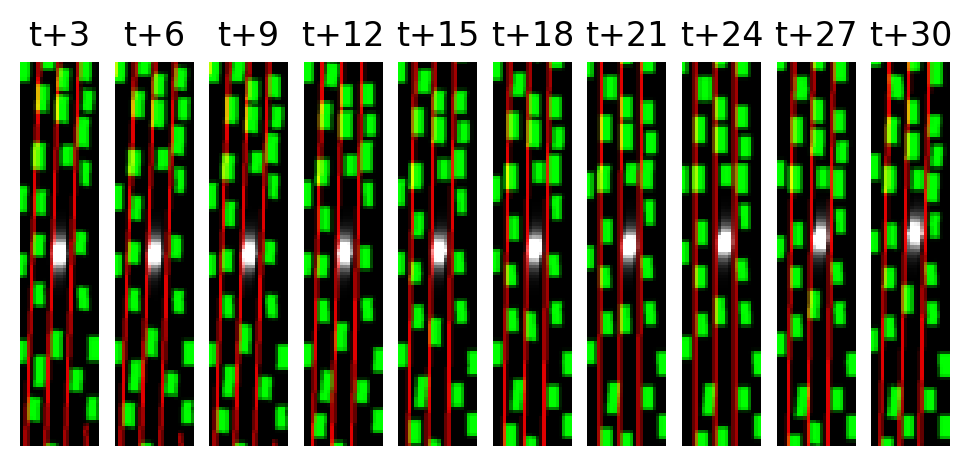

In [233]:
plt.figure(dpi=200)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.title(f't+{(i + 1)*3}')
    plt.imshow(mpcs['sgd'].cost.get_last_overlay()[0, i*3 + 2].permute(1, 2, 0).detach().cpu())
    plt.axis('off')